<a href="https://colab.research.google.com/github/shadiakiki1986/sklearn-digits-jitter/blob/master/sklearn_digits_with_jitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The digits dataset from sklearn, with jitter

- [sklearn load_digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)

Published at https://github.com/shadiakiki1986/sklearn-digits-jitter/

# get data

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()

# pad all the images such that translation doesn't lose info

In [2]:
# utility plotting code
# From https://www.codespeedy.com/image-augmentation-using-skimage-in-python/
#basic Function to display image side by side
from matplotlib import pyplot as plt
def plot_side(img1, img2, title1, title2, cmap = None):
    fig = plt.figure(tight_layout='auto', figsize=(5,5))
    fig.add_subplot(221)
    plt.title(title1)
    plt.imshow(img1, origin="lower")

    fig.add_subplot(222)
    plt.title(title2)
    plt.imshow(img2, cmap = None, origin="lower")
    return fig

In [3]:
import numpy as np
jitter_max = 3
digpad = {}
digpad["images"] = [np.pad(x, jitter_max, 'constant', constant_values=0) for x in digits.images]

digits.images[0].shape, digpad["images"][0].shape

((8, 8), (14, 14))

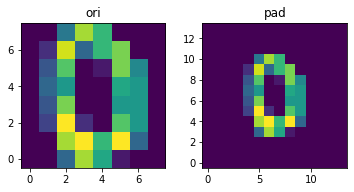

In [4]:
plot_side(digits.images[0], digpad["images"][0], "ori", "pad")
plt.show()

# generate jitter and check that it's balanced

## (deprecated) method 1: rng.integers: not jointly uniform though

In [5]:
# +1 to be inclusive of the high side
rng = np.random.default_rng()
size = len(digpad["images"])
size*=100 # FIXME increasing sample size to see if issue of not being jointly uniform is fixed
jitter_xy = rng.integers(low=-1*jitter_max, high=+1*jitter_max+1, size=(size,2))
jitter_xy.shape

(179700, 2)

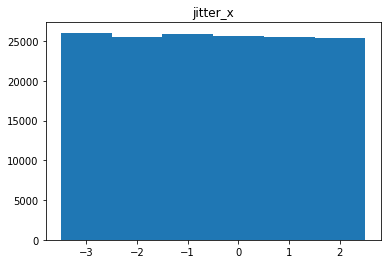

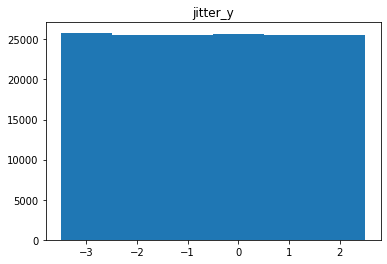

In [6]:
plt.hist(jitter_xy[:,0], bins=np.arange(jitter_xy.min(), jitter_xy.max()+1, 1)-.5)
plt.title("jitter_x")
plt.show()

plt.hist(jitter_xy[:,1], bins=np.arange(jitter_xy.min(), jitter_xy.max()+1, 1)-.5)
plt.title("jitter_y")
plt.show()

In [7]:
import pandas as pd
count_jitter = pd.DataFrame(jitter_xy, columns=["x","y"]).value_counts().unstack()
print(f"min: {count_jitter.min().min()}")
count_jitter - count_jitter.min().min()

min: 3533


y,-3,-2,-1,0,1,2,3
x,,,,,,,
-3,203,169,262,254,67,102,268
-2,131,138,0,163,125,163,77
-1,158,167,147,175,129,257,122
0,98,208,174,188,98,17,139
1,92,67,105,90,162,110,163
2,263,38,143,35,7,81,155
3,159,90,46,53,169,131,225


For (x,y) = (-3,-3), it is sampled 74 times, a third as much as (1,3) which is sampled 212 times => not balanced

In [8]:
del jitter_xy

## method 2: is jointly uniform

In [9]:
# util func
# overall distribution of jitter x/y pairs
import pandas as pd
def print_hist(jitter_xy):
  print(pd.DataFrame(jitter_xy, columns=["x","y"]).value_counts().unstack())

In [10]:
# numpy random number generator
rng = np.random.default_rng()

For the end jittering to be balanced overall AND per digit, get the locations of each digit

In [11]:
loc_t = []
for t in range(10):
  loc_t += np.where(digits.target == t)[0].tolist()

len(loc_t)

1797

In [12]:
loc_t[:3], digits.target[[0,10,20]]

([0, 10, 20], array([0, 0, 0]))

In [13]:
loc_t[200:203], digits.target[[218, 221, 227]]

([218, 221, 227], array([1, 1, 1]))

Start calculating jitter

In [14]:
# Option 1:
# cartesian product of possible jitter pairs
# https://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays
jitter_xy = np.array(np.meshgrid(
    range(-1*jitter_max, +1*jitter_max + 1, 1),
    range(-1*jitter_max, +1*jitter_max + 1, 1)
)).T.reshape((-1,2))
assert jitter_xy.shape == (49, 2)


# Option 2
# Just -1, 0, +1 of jitter_max
#jitter_xy = np.array(np.meshgrid(
#    [-1*jitter_max, 0, +1*jitter_max],
#    [-1*jitter_max, 0, +1*jitter_max]
#)).T.reshape((-1,2))
#assert jitter_xy.shape == (9, 2)

print(jitter_xy.T)

[[-3 -3 -3 -3 -3 -3 -3 -2 -2 -2 -2 -2 -2 -2 -1 -1 -1 -1 -1 -1 -1  0  0  0
   0  0  0  0  1  1  1  1  1  1  1  2  2  2  2  2  2  2  3  3  3  3  3  3
   3]
 [-3 -2 -1  0  1  2  3 -3 -2 -1  0  1  2  3 -3 -2 -1  0  1  2  3 -3 -2 -1
   0  1  2  3 -3 -2 -1  0  1  2  3 -3 -2 -1  0  1  2  3 -3 -2 -1  0  1  2
   3]]


In [15]:
print_hist(jitter_xy)

y   -3  -2  -1   0   1   2   3
x                             
-3   1   1   1   1   1   1   1
-2   1   1   1   1   1   1   1
-1   1   1   1   1   1   1   1
 0   1   1   1   1   1   1   1
 1   1   1   1   1   1   1   1
 2   1   1   1   1   1   1   1
 3   1   1   1   1   1   1   1


In [16]:
# Repeat the jitters to get one jitter per entry in the dataset
import math
ndig = 10
jrep = math.ceil(len(digits.images)/ndig/jitter_xy.shape[0])
assert jrep == 4 # for range option above
#assert jrep == 20 # for edges only
# Update: use np.repeat to get -3 -3 -3 -2 -2 -2 ... then np.tile to get -3 -3 -3 -2 -2 -2 ... -3 -3 -3 -2 -2 -2 ...
jitter_xy = np.repeat(jitter_xy, jrep, axis=0)
jitter_xy = np.tile(jitter_xy.T, ndig).T
assert jitter_xy.shape == (1960, 2) # for range option
#assert jitter_xy.shape == (1800, 2) # for edges option

In [17]:
print_hist(jitter_xy)

y   -3  -2  -1   0   1   2   3
x                             
-3  40  40  40  40  40  40  40
-2  40  40  40  40  40  40  40
-1  40  40  40  40  40  40  40
 0  40  40  40  40  40  40  40
 1  40  40  40  40  40  40  40
 2  40  40  40  40  40  40  40
 3  40  40  40  40  40  40  40


In [18]:
# for range option
jitter_xy[:5, :], jitter_xy[4*49-2:4*49+5, :] # , jitter_xy[100:103, :]

(array([[-3, -3],
        [-3, -3],
        [-3, -3],
        [-3, -3],
        [-3, -2]]), array([[ 3,  3],
        [ 3,  3],
        [-3, -3],
        [-3, -3],
        [-3, -3],
        [-3, -3],
        [-3, -2]]))

In [19]:
# randomly drop n jitters where n is the extra number of jitters we have from the repetition
jitter_drop = jitter_xy.shape[0] - len(digits.images)
assert jitter_drop == 1960 - 1797 # for range option
#assert jitter_drop == 1800 - 1797 # for edges option

# Note: high is excluded
# Update: instead of random integers, which could give the same integer more than once, get random without repetition
#jitter_drop = rng.integers(low=0, high=jitter_xy.shape[0], size=jitter_drop).tolist()
drop_ind = np.arange(jitter_xy.shape[0])
rng.shuffle(drop_ind)
jitter_drop = drop_ind[:jitter_drop]
assert jitter_drop.shape[0] == len(set(jitter_drop.tolist())) # no dupes

jitter_xy = np.delete(jitter_xy, jitter_drop, axis=0)
assert jitter_xy.shape == (1797, 2)

In [20]:
print_hist(jitter_xy)

y   -3  -2  -1   0   1   2   3
x                             
-3  39  38  36  35  36  39  33
-2  34  35  35  38  39  35  37
-1  37  36  34  34  35  37  34
 0  34  37  37  40  37  39  40
 1  39  35  35  35  39  36  40
 2  37  37  36  35  39  37  37
 3  37  34  38  39  37  38  37


In [21]:
# Update: shuffling will make a balanced set overall, but not per digit
#rng = np.random.default_rng()
#rng.shuffle(jitter_xy)

# distribute the jitters by digit
jitter_2 = np.zeros_like(jitter_xy)
for i, loc_i in enumerate(loc_t):
  jitter_2[loc_i, :] = jitter_xy[i, :]

assert jitter_2.shape == (1797, 2)

In [22]:
print_hist(jitter_2)

y   -3  -2  -1   0   1   2   3
x                             
-3  39  38  36  35  36  39  33
-2  34  35  35  38  39  35  37
-1  37  36  34  34  35  37  34
 0  34  37  37  40  37  39  40
 1  39  35  35  35  39  36  40
 2  37  37  36  35  39  37  37
 3  37  34  38  39  37  38  37


In [23]:
jitter_2[:10,:]

array([[-3, -3],
       [ 3,  3],
       [-3, -3],
       [ 3,  3],
       [-3, -2],
       [-3, -2],
       [-3, -1],
       [-3, -1],
       [-3, -2],
       [-3, -3]])

In [24]:
loc_t[175:185]
# transition from indeces of 0 to those of 1
# [1746, 1768, 1793, 1, 11, 21, 42, 47, 56, 70]

[1746, 1768, 1793, 1, 11, 21, 42, 47, 56, 70]

In [25]:
jitter_2[loc_t[:3],:], jitter_2[loc_t[(37-1):39],:], jitter_2[loc_t[(37*2-1):(37*2+2)],:], jitter_2[loc_t[175:185],:]

(array([[-3, -3],
        [-3, -3],
        [-3, -3]]), array([[-2, -1],
        [-2,  0],
        [-2,  0]]), array([[-1,  3],
        [-1,  3],
        [ 0, -3]]), array([[ 3,  2],
        [ 3,  3],
        [ 3,  3],
        [ 3,  3],
        [ 3,  3],
        [-3, -3],
        [-3, -3],
        [-3, -3],
        [-3, -3],
        [-3, -2]]))

In [26]:
jitter_xy = jitter_2
del jitter_2

In [27]:
print_hist(jitter_xy)

y   -3  -2  -1   0   1   2   3
x                             
-3  39  38  36  35  36  39  33
-2  34  35  35  38  39  35  37
-1  37  36  34  34  35  37  34
 0  34  37  37  40  37  39  40
 1  39  35  35  35  39  36  40
 2  37  37  36  35  39  37  37
 3  37  34  38  39  37  38  37


Much better joint uniform distribution.

Now check that the jitter per digit is also balanced

In [28]:
# count each digit
#digits.target[:3]
pd.Series(digits.target).value_counts().sort_index()

0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
dtype: int64

In [29]:
for t in range(10):
  print("")
  print(f"digit = {t}")
  print(pd.DataFrame(jitter_xy[digits.target==t, :], columns=["x","y"]).value_counts().unstack().fillna(0).astype(int))


digit = 0
y   -3  -2  -1   0   1   2   3
x                             
-3   4   4   4   4   4   4   4
-2   2   3   4   4   4   2   4
-1   4   2   4   2   4   4   4
 0   3   4   4   4   4   4   4
 1   4   2   4   3   4   3   4
 2   3   4   4   4   4   3   4
 3   4   4   4   4   4   4   2

digit = 1
y   -3  -2  -1   0   1   2   3
x                             
-3   6   4   2   4   4   4   3
-2   3   4   4   4   3   3   4
-1   4   4   4   3   2   4   3
 0   3   3   4   4   4   4   4
 1   4   4   3   4   4   4   4
 2   3   4   4   4   4   4   3
 3   4   3   3   4   4   3   6

digit = 2
y   -3  -2  -1   0   1   2   3
x                             
-3   2   3   4   3   4   4   3
-2   4   3   3   4   4   3   2
-1   4   4   4   3   4   4   4
 0   4   3   4   4   4   3   4
 1   4   4   4   4   4   4   4
 2   4   4   3   4   4   4   4
 3   3   3   3   4   4   4   2

digit = 3
y   -3  -2  -1   0   1   2   3
x                             
-3   7   6   4   4   3   4   3
-2   4   4   4   4   4   3

Finally.

# apply jitter

In [30]:
# test
for img, (jx, jy) in zip(digpad["images"], jitter_xy):
  print(img.shape, jx, jy)
  break

(14, 14) -3 -3


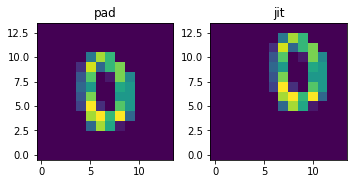

In [31]:
# use sklearn transform
# https://scikit-image.org/docs/dev/api/skimage.transform.html
from skimage.transform import warp
from skimage.transform import SimilarityTransform

my_translate = lambda img, jx, jy: warp(img, SimilarityTransform(translation=(jx, jy)))

# test
plot_side(digpad["images"][0], my_translate(digpad["images"][0], -2, -2), "pad", "jit")
plt.show()

In [32]:
digjit = {}
digjit["images"] = [
  my_translate(img, jx, jy)
  for img, (jx, jy)
  in zip(digpad["images"], jitter_xy)
]

len(digjit["images"]), digjit["images"][0].shape

(1797, (14, 14))

jitter = [-3 -3]


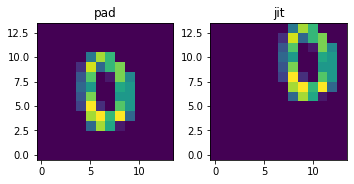

In [33]:
print(f"jitter = {jitter_xy[0,:]}")

plot_side(digpad["images"][0], digjit["images"][0], "pad", "jit")
plt.show()

In [34]:
def im2data(digxxx_img):
  return np.vstack([img.reshape((-1,1)).squeeze() for img in digxxx_img])
  
digjit["data"] = im2data(digjit["images"])
assert digjit["data"].shape == (1797, 196)

digpad["data"] = im2data(digpad["images"])
assert digpad["data"].shape == (1797, 196)

In [35]:
digjit["data"].astype(int).dtype

dtype('int64')

In [36]:
# save to csv, like the sklearn format at https://github.com/scikit-learn/scikit-learn/tree/main/sklearn/datasets/data
fn_csv = "digits_jitter.csv"
!rm -rf "$fn_csv" "{fn_csv}.gz"
np.savetxt(fn_csv, digjit["data"].astype(int), delimiter=",", fmt="%i")

!du -sh "$fn_csv"
!wc -l "$fn_csv"
!head -n3 "$fn_csv"
!echo "..."
!tail -n3 "$fn_csv"

!gzip "$fn_csv"
!du -sh "{fn_csv}.gz"

720K	digits_jitter.csv
1797 digits_jitter.csv
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,13,9,1,0,0,0,0,0,0,0,0,0,0,13,15,10,15,5,0,0,0,0,0,0,0,0,3,15,2,0,11,8,0,0,0,0,0,0,0,0,4,12,0,0,8,8,0,0,0,0,0,0,0,0,5,8,0,0,9,8,0,0,0,0,0,0,0,0,4,11,0,1,12,7,0,0,0,0,0,0,0,0,2,14,5,10,12,0,0,0,0,0,0,0,0,0,0,6,13,10,0,0,0
0,0,0,12,13,5,0,0,0,0,0,0,0,0,0,0,0,11,16,9,0,0,0,0,0,0,0,0,0,0,3,15,16,6,0,0,0,0,0,0,0,0,0,7,15,16,16,2,0,0,0,0,0,0,0,0,0,0,1,16,16,3,0,0,0,0,0,0,0,0,0,0,1,16,16,6,0,0,0,0,0,0,0,0,0,0,1,16,16,6,0,0,0,0,0,0,0,0,0,0,0,11,16,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [37]:
# Also save the padded version (without the jitter)
fn_csv = "digits_padded.csv"
!rm -rf "$fn_csv" "{fn_csv}.gz"
np.savetxt(fn_csv, digpad["data"].astype(int), delimiter=",", fmt="%i")

!du -sh "$fn_csv"
!wc -l "$fn_csv"
!head -n3 "$fn_csv"
!echo "..."
!tail -n3 "$fn_csv"

!gzip "$fn_csv"
!du -sh "{fn_csv}.gz"

720K	digits_padded.csv
1797 digits_padded.csv
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,13,9,1,0,0,0,0,0,0,0,0,0,0,13,15,10,15,5,0,0,0,0,0,0,0,0,3,15,2,0,11,8,0,0,0,0,0,0,0,0,4,12,0,0,8,8,0,0,0,0,0,0,0,0,5,8,0,0,9,8,0,0,0,0,0,0,0,0,4,11,0,1,12,7,0,0,0,0,0,0,0,0,2,14,5,10,12,0,0,0,0,0,0,0,0,0,0,6,13,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,13,5,0,0,0,0,0,0,0,0,0,0,0,11,16,9,0,0,0,0,0,0,0,0,0,0,3,15,16,6,0,0,0,0,0,0,0,0,0,7,15,16,16,2,0,0,0,0,0,0,0,0,0,0,1,16,16,3,0,0,0,0,0,0,0,0,0,0,1,16,16,6,0,0,0,0,0,0,0,0,0,0,1,16,16,6,0,0,0,0,0,0,0,0,0,0,0,11,16,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,15,12,0,0,0,0,0,0,0,0,0,0,3,16,15,14,0,